# Error estimation
**Note: first run of this cell takes a while**

In [1]:

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
import util, config, plots
import ipynbname
import pandas as pd
import numpy as np
import json
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm


/Users/ymdt/src/dreem/dreem/aggregate/main.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  df_samples = check_samples(pd.read_csv(samples)) if samples is not '' else None


## Simulation of standard deviation w.r.t modification rate

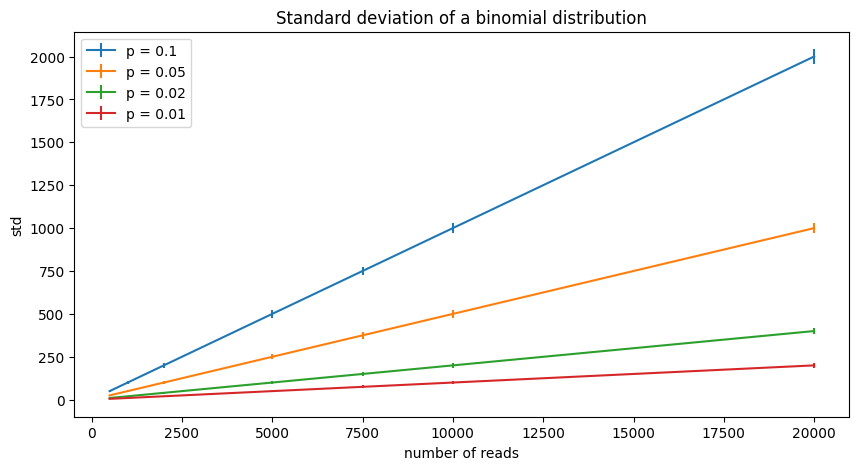

In [2]:
# plot the mean of a binomial distribution with n=[500, 1000, 2000, 5000, 7500, 10000, 20000] and p=[0.01, 0.02, 0.05, 0.1]
# use the standard deviation as a measure of error
import numpy as np
import matplotlib.pyplot as plt

n = np.array([500, 1000, 2000, 5000, 7500, 10000, 20000])
p = np.array([0.01, 0.02, 0.05, 0.1])
p = p[::-1]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for p_ in p:
    ax.errorbar(n, [p_]*n, label='p = {}'.format(p_), yerr=np.sqrt(n*p_*(1-p_)))
ax.set(xlabel='number of reads', ylabel='std', title='Standard deviation of a binomial distribution')
ax.legend()
plt.show()
    

## Barcode replicates simulation
### Experimental: what distributino to expect?

## Introduction

The bootstrap always fits a binomial distribution, independent of the underlying distribution. 

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Full dataset stats
N, D = 10000, 1000
data = np.concatenate(( (np.random.rand(N, D//2) < 0.02).astype(int), (np.random.rand(N, D//2) < 0.03).astype(int) ), axis=1)
muts_count = np.sum(data, axis=0)


# Stats on one column of data
data_col = data[:, np.random.randint(0, D-1)]

bootstrap_data = np.random.choice(data_col, size=(N, D), replace=True)

muts_count_bs = np.sum(bootstrap_data, axis=0)

# Make a Plotly subplot with the histogram of muts_count on the first row and the bootstrapping on the second row
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

fig.add_trace(go.Histogram(x=muts_count, histnorm='probability density', name='Original dataset' ), col=1, row=1)

fig.add_trace(go.Histogram(x=muts_count_bs, histnorm='probability density', name='bootstrap data'), col=1, row=2)

# Draw a binomial distribution on top of the histogram, with n=1000 and p estimated from the data
from scipy.stats import binom
x = np.arange(min(muts_count_bs), max(muts_count_bs)).astype(int)
fig.add_trace(go.Scatter(x=x, y=binom.pmf(x, len(data_col), np.count_nonzero(data_col)/len(data_col)), mode='lines', name='binomial'), col=1, row=2)

## Load real dataset

In [4]:
data = pd.read_orc('../../bv/01_1_s22_reads_3043.orc')

def process_data(data):
    data = data.to_numpy(dtype=np.byte).astype(float)
    data[data == 0] = 0
    data[data < 0] = 128
    data[data < 64] = 0
    data[data > 0] = 1
    return data

data = process_data(pd.read_orc('../../bv/01_1_S22_reads_3081.orc'))
sample = data[np.random.randint(0, data.shape[0], size=N)]
observed_freq = sample.sum(axis=0)/N

# Bootstrap vs binomial distribution


## Bootstrap
### Define bootstrap function

In [5]:
def bootstrap(sample, n=1000):
    """
    Bootstrap the sample
    """
    n, r = sample.shape
    res = np.zeros((n, r))
    for i in range(n):
        res[i] = sample[np.random.randint(0, n, n)].sum(axis=0)
    return res

def predict_confidence_interval_bootstrap(sample, bootstrap_iterations=1000):
    bs = bootstrap(sample, n=bootstrap_iterations)
    lower_bound, upper_bound = np.percentile(bs, [2.5, 97.5], axis=0)/size_sample
    return lower_bound, upper_bound
    

## Binomial distribution

### Define function

In [6]:
def predict_confidence_interval_binomial_distribution(observed_freq, size_sample):
    """
    Predict the confidence interval using the binomial distribution
    """
    lower_bound = observed_freq - 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    upper_bound = observed_freq + 1.96*np.sqrt(observed_freq*(1-observed_freq)/size_sample)
    return lower_bound, upper_bound
    



##  Wilson score 
### Define function

In [7]:
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = np.sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

## Clopper-Pearson 
### Define function

In [8]:
def clopper_pearson(*args):
    return sm.stats.proportion_confint(*args, method='beta', alpha=0.05)

## Agresti-Coull
### Define function

In [9]:
def agresti_coull(*args):
    return sm.stats.proportion_confint(*args, method='agresti_coull', alpha=0.05)

## Poisson

In [10]:
import scipy

def predict_confidence_interval_poisson(observed_freq, size_sample, alpha=0.05):
    cov = size_sample
    mut = observed_freq*size_sample
    return 0.5*scipy.stats.chi2.ppf(alpha/2, df=2*mut)/cov, 0.5*scipy.stats.chi2.ppf(1-alpha/2, df=2*(mut+1))/cov


# Let's compare the different methods

In [11]:

n_trials_per_dataset = 1
bootstrap_iterations = 10
methods = ['bootstrap', 'binomial', 'wilson', 'clopper_pearson', 'agresti_coull', 'poisson']
size_samples = [500, 1000, 2000, 3000, 5000, 10000]

failures_df = pd.DataFrame()
size_df = pd.DataFrame()

for size_sample in size_samples:
    failures = {m:[] for m in methods}
    size_ci = {m:[] for m in methods}
    sub_rate_vector = []
    failures_vector =  {m:[] for m in methods}
    
    for f in os.listdir('../../bv'):
        
        # read dataset
        data = process_data(pd.read_orc('../../bv/' + f))
        true_mutation_rate = data.sum(axis=0)/data.shape[0]

        fail = {m:[] for m in methods}
        size = {m:[] for m in methods}
        
        for _ in range(n_trials_per_dataset):
            
            # generate a new sample
            sample = data[np.random.randint(0, data.shape[0], size=size_sample)]
            observed_freq = sample.sum(axis=0)/size_sample
            sub_rate_vector.append(true_mutation_rate)
            
            # count failures bootstrap
            lb_bs, ub_bs = predict_confidence_interval_bootstrap(sample, bootstrap_iterations=bootstrap_iterations)
            fail['bootstrap'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['bootstrap'].append(np.mean(ub_bs - lb_bs))
            failures_vector['bootstrap'].append(np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate))
            
            # count failures binomial
            lb_bin, ub_bin = predict_confidence_interval_binomial_distribution(observed_freq, size_sample)
            fail['binomial'].append(100*np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate).sum()/data.shape[1])
            size['binomial'].append(np.mean(ub_bin - lb_bin))
            failures_vector['binomial'].append(np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate))
            
            # count Wilson failures
            lb_wilson, ub_wilson = wilson(observed_freq, size_sample)
            fail['wilson'].append(100*np.logical_or(ub_wilson < true_mutation_rate, lb_wilson > true_mutation_rate).sum()/data.shape[1])
            size['wilson'].append(np.mean(ub_wilson - lb_wilson))
            failures_vector['wilson'].append(np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate))
            
            # count Clopper-Pearson failures
            lb_cp, ub_cp = clopper_pearson(observed_freq*size_sample, size_sample)
            fail['clopper_pearson'].append(100*np.logical_or(ub_cp < true_mutation_rate, lb_cp > true_mutation_rate).sum()/data.shape[1])
            size['clopper_pearson'].append(np.mean(ub_cp - lb_cp))
            failures_vector['clopper_pearson'].append(np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate))
            
            # count Agresti-Coull failures
            lb_ac, ub_ac = agresti_coull(observed_freq*size_sample, size_sample)
            fail['agresti_coull'].append(100*np.logical_or(ub_ac < true_mutation_rate, lb_ac > true_mutation_rate).sum()/data.shape[1])
            size['agresti_coull'].append(np.mean(ub_ac - lb_ac))
            failures_vector['agresti_coull'].append(np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate))
            
            # count Poisson failures
            lb_poisson, ub_poisson = predict_confidence_interval_poisson(observed_freq, size_sample)
            fail['poisson'].append(100*np.logical_or(ub_poisson < true_mutation_rate, lb_poisson > true_mutation_rate).sum()/data.shape[1])
            size['poisson'].append(np.mean(ub_poisson - lb_poisson))
            failures_vector['poisson'].append(np.logical_or(ub_bs < true_mutation_rate, lb_bs > true_mutation_rate))

        for m in methods:
            failures[m].append(fail[m])
            size_ci[m].append(size[m])
        #    print(f'{n_dataset}: {m}: {np.mean(failures[m][-1])}% failure rate')
        #print('----------------------------------------------------------')
    
    df = pd.DataFrame(
        {
            'Bootstrap': np.array(failures['bootstrap']).flatten(), 
            'Binomial': np.array(failures['binomial']).flatten(), 
            'Wilson': np.array(failures['wilson']).flatten(),
            'Clopper-Pearson': np.array(failures['clopper_pearson']).flatten(),
            'Agresti-Coull': np.array(failures['agresti_coull']).flatten(),
            'Poisson': np.array(failures['poisson']).flatten(),
            'size_sample': size_sample,
        })

    failures_df = pd.concat([failures_df, df], axis=0)

    df = pd.DataFrame(
        {
            'Bootstrap': np.array(size_ci['bootstrap']).flatten(), 
            'Binomial': np.array(size_ci['binomial']).flatten(), 
            'Wilson': np.array(size_ci['wilson']).flatten(),
            'Clopper-Pearson': np.array(size_ci['clopper_pearson']).flatten(),
            'Agresti-Coull': np.array(size_ci['agresti_coull']).flatten(),
            'Poisson': np.array(size_ci['poisson']).flatten(),
            'size_sample': size_sample        
        })
    size_df = pd.concat([size_df, df], axis=0)
    
fig = px.box(failures_df, y=[c for c in df.columns if c != 'size_sample'], color='size_sample', title='Failure rate of the confidence interval methods. n_bootstrap = {}, n_iter = {} iterations *{} datasets'.format(bootstrap_iterations, n_trials_per_dataset, len(os.listdir('../../bv'))))
fig.update_yaxes(title_text="Failure rate (%)")
fig.update_xaxes(title_text="Method")

# add a horizontal line at y=5 all the way across the figure legend y=5 
fig.add_shape(type="line", x0=0, y0=5, x1=1, y1=5, line=dict(color="Green", width=2, dash="dash"), xref="paper", yref="y")

# add a horizontal line at y=2.5
fig.add_shape(type="line", x0=0, y0=2.5, x1=1, y1=2.5, line=dict(color="Red", width=2, dash="dash", ), xref="paper", yref="y")

util.save_plotly_fig(ipynbname.path(), '[A] Failure rate of the confidence interval methods', fig)

fig.show()
    
fig = px.box(size_df, y=[c for c in df.columns if c != 'size_sample'], color='size_sample', title='Size of the confidence interval methods. n_bootstrap = {}, n_iter = {} iterations *{} datasets'.format(bootstrap_iterations, n_trials_per_dataset, len(os.listdir('../../bv'))))
fig.update_yaxes(title_text="Size of the CI")
fig.update_xaxes(title_text="Method")
fig.show()

# save to file
util.save_plotly_fig(ipynbname.path(), '[B] Size of the confidence interval methods', fig)

In [12]:
sub_rate_vector
failures_vector

df = pd.DataFrame(
    {
        'Bootstrap': np.array(failures_vector['bootstrap']).flatten().astype(int), 
        'Binomial': np.array(failures_vector['binomial']).flatten().astype(int), 
        'Wilson': np.array(failures_vector['wilson']).flatten().astype(int), 
        'Clopper-Pearson': np.array(failures_vector['clopper_pearson']).flatten().astype(int), 
        'Agresti-Coull': np.array(failures_vector['agresti_coull']).flatten().astype(int), 
        'Poisson': np.array(failures_vector['poisson']).flatten().astype(int), 
        'size_sample': [s for s in size_samples for i in range(len(np.array(failures_vector['bootstrap']).flatten())//len(size_samples))]
    }, 
    index = np.array(sub_rate_vector).flatten()
    )


df = df[df.index < 0.1].reset_index()
#df = df[df.size_sample == 1000]

# plot the index distributino
fig = go.Figure()
fig.add_trace(go.Histogram(x=df['index'], name='Mutation rate', marker_color='red', opacity=0.5))
fig.update_layout(title='Mutation rate distribution', xaxis_title='Mutation rate', yaxis_title='Count')
#fig.show()

out = pd.DataFrame()
df.reset_index(inplace=True)
df.rename(columns={'index': 'mut_rate'}, inplace=True)
for size_sample, g in df.groupby('size_sample'):
    # group g['index'] by 0.01 from 0 to 0.15
    bins = np.arange(0, 100,1)
    for col in df.columns:
        if col != 'mut_rate' and col != 'size_sample' and col != 'level_0':
            for mi, ma in zip(bins[:-1], bins[1:]):
                out.loc[size_sample, col] = g[col].where((g['mut_rate'] >= mi) & (g['mut_rate'] < ma), inplace=True)
out

,Bootstrap,Binomial,Wilson,Clopper-Pearson,Agresti-Coull,Poisson
500,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN
2000,NaN,NaN,NaN,NaN,NaN,NaN
3000,NaN,NaN,NaN,NaN,NaN,NaN
5000,NaN,NaN,NaN,NaN,NaN,NaN
10000,NaN,NaN,NaN,NaN,NaN,NaN


## Conclusion

I tested the performance of different methods (bootstrap, binomial, wilson, copper-pearson, agresti-coull, poisson). I used the following method:
1. load a real bitvector
2. compute the true mutation rate of the bitvector
3. draw n reads from the bitvector, n in [500, 1000, 2000, 3000, 5000, 10000]
4. use each method to predict a 95% confidence interval
5. for each base, count if the true mutation rate was in the confidence interval. Compute a failure rate. It should be 5%.
6. reiterate the previous step 300 times for each value of n. You have now a distribution of the failure rate for each method and different values of n

### The keys outputs I see:
1. The most stable method across different values of N if `Wilson`.
2. The best performers when using a large amount of reads (3000+) are `Bootstrap` and `Binomial` but are very sensitive to a lower amount of reads.
3. Agresti, Clopper and Poisson “overkill” the confidence interval, so they are at ~3% error at 500 reads, which means the CI are less informative.


## Let's compare replicates with different methods

In [13]:
%reload_ext autoreload
from study_gen import study
from plots import *
from config import bio_replicates_samples

for samples in bio_replicates_samples[4:]:
    plots.biological_replicates_fisher_pearson(study, samples[:2])['fig'].show()
    


Reading study from df.feather...
Done reading study from df.feather.


KeyError: "['sub_rate'] not in index"

##